# Entities

## Init

### Imports

In [1]:
import spacy
import random
import string
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from spacy import displacy
from itertools import chain
from hd_utils import monitor
from collections import Counter
from sklearn.datasets.lfw import Bunch

### Plot

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

### Args

In [3]:
args = Bunch()

## Spacy 101

In [4]:
sample_text = '''But Google is starting from behind. The company made a late push \
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa \
software, which runs on its Echo and Dot devices, have clear leads in \
consumer adoption.'''
sample_text

'But Google is starting from behind. The company made a late push into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa software, which runs on its Echo and Dot devices, have clear leads in consumer adoption.'

In [5]:
nlp = spacy.load('en')
doc = nlp(sample_text)

In [6]:
for token in doc[:10]:
    print(f'text={token.text} lemma={token.lemma_} pos={token.pos_}')

text=But lemma=but pos=CCONJ
text=Google lemma=google pos=PROPN
text=is lemma=be pos=VERB
text=starting lemma=start pos=VERB
text=from lemma=from pos=ADP
text=behind lemma=behind pos=ADV
text=. lemma=. pos=PUNCT
text=The lemma=the pos=DET
text=company lemma=company pos=NOUN
text=made lemma=make pos=VERB


In [7]:
print([chunk.text for chunk in doc.noun_chunks])

['Google', 'The company', 'a late push', 'hardware', 'Apple', 'Siri', 'iPhones', 'Amazon’s Alexa software', 'its Echo', 'Dot devices', 'clear leads', 'consumer adoption']


In [8]:
options = {'compact': True, 'bg': '#09a3d5',
           'color': 'white', 'font': 'Source Sans Pro'}
displacy.render(nlp(next(doc.sents).text), style='dep', options=options, jupyter=True)

In [9]:
doc.user_data['title'] = 'Apple vs Google'
displacy.render(doc, style='ent', jupyter=True)

## Read

In [10]:
args.data_text_path = 'docstring_data_text.hdf5'

In [11]:
%time df = pd.read_hdf(args.data_text_path)
df.shape

CPU times: user 1.63 s, sys: 160 ms, total: 1.79 s
Wall time: 257 ms


(149499, 1)

In [12]:
df.head()

,text
0,Find globals in this statement.
1,Returns True if the input phrase has a negativ...
2,Returns True if the input phrase has a positiv...
3,Returns: DCNL A speaker implementation availab...
4,Gets the keyword phrases from the keywords fil...


## Collect entities

In [13]:
args.informative_poses = {'NOUN', 'PROPN'}
args.stop_words = {"doesn\\'t", 'it\\', 'user\\', 'return', ':return'}
args.log_step = 5000
args.good_chars = string.ascii_lowercase + ' '

In [14]:
def fetch_entity(desc):
    def norm(word):
        return word.strip().lower()
    
    def is_valid(word):
        return not nlp.vocab[word].is_stop and not 'dcnl' in word \
                    and not '_' in word and len(word) > 1 \
                    and not word in args.stop_words \
                    and all(char in args.good_chars for char in word)
    
    # Forming candidates
    doc = nlp(desc)
    ents = (ent.text for ent in doc.ents)
    lemmas = (token.lemma_ for token in doc \
              if token.pos_ in args.informative_poses and not token.lemma_.startswith('-'))
    noun_chunks = (chunk.text for chunk in doc.noun_chunks)
    candidates = (norm(candidate) for candidate in chain(ents, lemmas, noun_chunks))
    
    return set(candidate for candidate in candidates if is_valid(candidate))

In [15]:
@monitor('[1.3.1] Collect entities', log_step=args.log_step, log_total=len(df))
def collect_entities(descs, *, log):
    entities = []
    for i, desc in enumerate(tqdm(descs)):
        entities.append(fetch_entity(desc))
        log.istep(i)
    return entities

In [16]:
entities = collect_entities(df.text)
assert len(df) == len(entities)
random.sample(entities, 1)

100%|██████████| 149499/149499 [54:26<00:00, 45.77it/s]


[{'basic types', 'test', 'type'}]

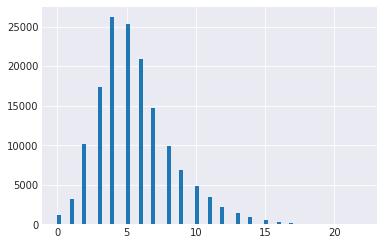

In [17]:
pd.Series([len(i_entities) for i_entities in entities]).hist(bins=75);

## Analysis

In [18]:
@monitor('[1.3.2] Join entities', log_step=args.log_step, log_total=len(entities))
def join_entities(entities, *, log):
    cum_cnt = Counter()
    for i, entity in enumerate(tqdm(entities)):
        cum_cnt += Counter(entity)
        log.istep(i)
    return cum_cnt

In [19]:
ecnts = join_entities(entities)
len(ecnts)

100%|██████████| 149499/149499 [21:56<00:00, 113.57it/s]


146588

In [20]:
str(ecnts.most_common(50))

"[('test', 16566), ('list', 7553), ('object', 7070), ('file', 6767), ('value', 6249), ('method', 5718), ('string', 5551), ('function', 5534), ('user', 5240), ('instance', 4873), ('datum', 4139), ('request', 3627), ('param', 3257), ('type', 3155), ('returns', 3087), ('a list', 3053), ('error', 2939), ('parameter', 2903), ('number', 2874), ('message', 2799), ('argument', 2690), ('default', 2667), ('field', 2653), ('path', 2624), ('tests', 2524), ('class', 2479), ('command', 2232), ('attribute', 2124), ('key', 2117), ('api', 2095), ('response', 2078), ('state', 2024), ('information', 2022), ('result', 2020), ('exception', 2016), ('dictionary', 1966), ('line', 1949), ('server', 1925), ('module', 1913), ('group', 1896), ('model', 1885), ('version', 1883), ('connection', 1880), ('page', 1848), ('image', 1848), ('directory', 1833), ('dict', 1788), ('url', 1785), ('output', 1767), ('content', 1725)]"

In [21]:
entities = [sorted(entity, key=lambda x: ecnts[x])[:5] for entity in tqdm(entities)]
assert len(df) == len(entities)
random.sample(entities, 1)

100%|██████████| 149499/149499 [00:01<00:00, 131827.03it/s]


[['step object', 'step definitions', 'first argument', 'step', 'definition']]

In [22]:
def linearize(entities):
    return ' '.join(sorted('-'.join(entity.split()) for entity in entities))

In [23]:
entities = [linearize(i_entities) for i_entities in tqdm(entities)]
assert len(df) == len(entities)
random.sample(entities, 1)

100%|██████████| 149499/149499 [00:00<00:00, 230050.91it/s]


['a-dictionary all-target-links dictionary link target']

In [24]:
df['tags'] = entities
df.shape

(149499, 2)

In [25]:
df.head()

,text,tags
0,Find globals in this statement.,global globals statement this-statement
1,Returns True if the input phrase has a negativ...,a-negative-sentiment arguments phrase sentimen...
2,Returns True if the input phrase has a positiv...,a-positive-sentiment arguments phrase sentimen...
3,Returns: DCNL A speaker implementation availab...,a-speaker-implementation no-speaker-implementa...
4,Gets the keyword phrases from the keywords fil...,jasper keyword-phrases the-jasper-data-dir the...


In [26]:
df = df[df.tags.map(len) > 0].copy()
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.shape

(148378, 2)

In [27]:
df.head()

,text,tags
0,Find globals in this statement.,global globals statement this-statement
1,Returns True if the input phrase has a negativ...,a-negative-sentiment arguments phrase sentimen...
2,Returns True if the input phrase has a positiv...,a-positive-sentiment arguments phrase sentimen...
3,Returns: DCNL A speaker implementation availab...,a-speaker-implementation no-speaker-implementa...
4,Gets the keyword phrases from the keywords fil...,jasper keyword-phrases the-jasper-data-dir the...


In [28]:
assert (df.index == list(range(len(df)))).all()

## Save

In [29]:
args.save_path = 'docstring_data.hdf5'

In [30]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='f', complevel=9)

CPU times: user 144 ms, sys: 52 ms, total: 196 ms
Wall time: 195 ms


In [31]:
!du -sh $args.save_path

19M	docstring_data.hdf5


## End

In [32]:
args

{'data_text_path': 'docstring_data_text.hdf5',
 'good_chars': 'abcdefghijklmnopqrstuvwxyz ',
 'informative_poses': {'NOUN', 'PROPN'},
 'log_step': 5000,
 'save_path': 'docstring_data.hdf5',
 'stop_words': {':return', "doesn\\'t", 'it\\', 'return', 'user\\'}}